In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.profiler import Profiler, AdvancedProfiler
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl

/usr/workspace/mlmfem/anaconda3/envs/ptl_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path='.'

In [3]:
scaled_Qdata = pd.read_csv(f'{path}/scaled_QdataKn32width1e-02cm.csv', header=0, index_col=0)  #qdata with Knudsen
print(scaled_Qdata.shape)
scaled_Qdata.head()

(9463, 88)


,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9,...,n_10,n_11,n_12,n_13,n_14,n_15,n_16,Qimpact_c-1,Qimpact_c,Qimpact_c+1
0.006199,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,...,-0.387379,-0.387291,-0.387195,-0.387090,-0.386979,-0.386861,-0.386738,-1.047110,-1.042031,-1.036952
0.006218,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,...,-0.387376,-0.387288,-0.387191,-0.387087,-0.386975,-0.386858,-0.386734,-1.046952,-1.041873,-1.036793
0.006237,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,...,-0.387374,-0.387285,-0.387188,-0.387084,-0.386972,-0.386854,-0.386730,-1.046793,-1.041714,-1.036634
0.006256,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,...,-0.387371,-0.387282,-0.387185,-0.387080,-0.386968,-0.386850,-0.386726,-1.046634,-1.041555,-1.036476
0.006274,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,-0.390936,...,-0.387368,-0.387279,-0.387182,-0.387077,-0.386965,-0.386846,-0.386722,-1.046476,-1.041396,-1.036317


In [4]:
validationsize=1000 #how many samples will be used as traindata
testsize=1000

In [5]:
shuffled_Qdata=scaled_Qdata.sample(n=scaled_Qdata.shape[0])

validation_data=shuffled_Qdata.iloc[:validationsize]
test_data=scaled_Qdata
train_data=shuffled_Qdata.iloc[validationsize+testsize:]

print('Training dataset size: ', train_data.shape, '\nTesting dataset size: ',test_data.shape,'\nValidation dataset size: ', validation_data.shape)

Training dataset size:  (7463, 88) 
Testing dataset size:  (9463, 88) 
Validation dataset size:  (1000, 88)


In [6]:
threePoint = False
if (threePoint):
    target_fields = ['Qimpact_c-1','Qimpact_c','Qimpact_c+1']
else:
    target_fields = ['Qimpact_c']
drop_fields = ['Qimpact_c-1','Qimpact_c','Qimpact_c+1']

train_features, train_targets = train_data.drop(drop_fields, axis=1), train_data[target_fields]
test_features, test_targets = test_data.drop(drop_fields, axis=1), test_data[target_fields]
validation_features, validation_targets = validation_data.drop(drop_fields, axis=1), validation_data[target_fields]

In [7]:
l_rate = 0.1
mse_loss = nn.MSELoss(reduction = 'mean')

In [8]:
train_features.shape[1]

85

In [9]:
class Regression(pl.LightningModule):
    
### The Model ### 

    # Question: what will your model architecture look like?
    # Initialize the layers
    # Here we have one input layer (size 56 #3N as we have 56 #3N features), one hidden layer (size 10), 
    # and one output layer (size 1 as we are predicting a single value)
    def __init__(self):
        super(Regression, self).__init__()
        N1 = 30
        N2 = 10
        self.fc1 = nn.Linear(train_features.shape[1], N1)
        self.fc2 = nn.Linear(N1, N2)
        if (threePoint):
            self.fc3 = nn.Linear(N2, 3)
        else:
            self.fc3 = nn.Linear(N2, 1)            

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

### Data loader ### 
    def train_dataloader(self):
        train_dataset = TensorDataset(torch.tensor(train_features.values).float(), torch.tensor(train_targets[target_fields].values).float())
        train_loader = DataLoader(dataset = train_dataset, batch_size = 128)
        return train_loader
        
    def val_dataloader(self):
        validation_dataset = TensorDataset(torch.tensor(validation_features.values).float(),\
                                           torch.tensor(validation_targets[target_fields].values).float())
        validation_loader = DataLoader(dataset = validation_dataset, batch_size = 128)
        return validation_loader
    
    def test_dataloader(self):
        test_dataset = TensorDataset(torch.tensor(test_features.values).float(), torch.tensor(test_targets[target_fields].values).float())
        test_loader = DataLoader(dataset = test_dataset, batch_size = 128)
        return test_loader

### The Optimizer ### 
    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=l_rate)

### Training ### 
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        # Add logging
        logs = {'loss': loss}
        return {'loss': loss, 'log': logs}

### Validation ### 
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        return {'val_loss': loss}

    # Define validation epoch end
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

### Testing ###     
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        correct = torch.sum(logits == y.data)
        
        predictions_pred.append(logits)
        predictions_actual.append(y.data)
        return {'test_loss': loss, 'test_correct': correct, 'logits': logits}
    
    # Define test end
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        logs = {'test_loss': avg_loss}      
        return {'avg_test_loss': avg_loss, 'log': logs, 'progress_bar': logs }

In [10]:
model = Regression()
trainer = Trainer(max_epochs = 100)  # Option to check if it's working at all: fast_dev_run=True 
                                    # Option to implement early stopping: early_stop_callback=True
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 2.6 K 
1 | fc2  | Linear | 310   
2 | fc3  | Linear | 11    
--------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


/usr/workspace/mlmfem/anaconda3/envs/ptl_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/workspace/mlmfem/anaconda3/envs/ptl_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  88%|████████████████████████▋   | 59/67 [00:00<00:00, 154.61it/s, loss=0.157, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 1:  88%|███████████████████████▊   | 59/67 [00:00<00:00, 153.51it/s, loss=0.0579, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 2:  88%|███████████████████████▊   | 59/67 [00:00<00:00, 160.65it/s, loss=0.0378, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 3:  88%|███████████████████████▊   | 59/67 [00:00<00:00, 161.82it/s, loss=0.0253, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 4:  88%|███████████████████████▊   | 59/67 [00:00<00:00, 159.04it/s, loss=0.0182, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 5:  88%|███████████████████████▊   | 59/67 [00:00<00:00, 164.02it/s, loss=0.0153, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 6:  88%|███████████████████████▊   | 59/67 [00:00<00:00, 162.83it/s, loss=0.0126, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 7:  88%|███████████████████████▊   | 59/67 [00:00<00:00, 162.75it/s, loss=0.0107, v_num=2]
Validat

Epoch 8:  88%|██████████████████████▉   | 59/67 [00:00<00:00, 165.57it/s, loss=0.00941, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 9:  88%|██████████████████████▉   | 59/67 [00:00<00:00, 160.68it/s, loss=0.00829, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 10:  88%|██████████████████████   | 59/67 [00:00<00:00, 163.00it/s, loss=0.00723, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 11:  88%|██████████████████████   | 59/67 [00:00<00:00, 162.07it/s, loss=0.00628, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 12:  88%|██████████████████████   | 59/67 [00:00<00:00, 166.34it/s, loss=0.00569, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 13:  88%|██████████████████████   | 59/67 [00:00<00:00, 159.73it/s, loss=0.00524, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 14:  88%|██████████████████████   | 59/67 [00:00<00:00, 161.82it/s, loss=0.00487, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 14:  90%|██████████████████████▍  | 60/67 [00:00<00:00, 160.45it/s, loss=0.00487, v_num=2]


Epoch 15:  88%|██████████████████████   | 59/67 [00:00<00:00, 162.63it/s, loss=0.00462, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 16:  88%|██████████████████████   | 59/67 [00:00<00:00, 160.03it/s, loss=0.00448, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 17:  88%|██████████████████████▉   | 59/67 [00:00<00:00, 163.20it/s, loss=0.0042, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 18:  88%|██████████████████████   | 59/67 [00:00<00:00, 162.24it/s, loss=0.00391, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 19:  88%|███████████████████████▊   | 59/67 [00:00<00:00, 162.86it/s, loss=0.002, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 20:  88%|██████████████████████   | 59/67 [00:00<00:00, 164.40it/s, loss=0.00266, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 21:  88%|██████████████████████   | 59/67 [00:00<00:00, 162.26it/s, loss=0.00173, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 21:  93%|███████████████████████▏ | 62/67 [00:00<00:00, 162.32it/s, loss=0.00173, v_num=2]


Epoch 22:  88%|██████████████████████   | 59/67 [00:00<00:00, 163.72it/s, loss=0.00255, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 23:  88%|██████████████████████▉   | 59/67 [00:00<00:00, 163.04it/s, loss=0.0012, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 24:  88%|██████████████████████   | 59/67 [00:00<00:00, 165.36it/s, loss=0.00194, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 25:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 165.87it/s, loss=0.000911, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 26:  88%|██████████████████████   | 59/67 [00:00<00:00, 161.95it/s, loss=0.00111, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 27:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 162.23it/s, loss=0.000834, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 28:  88%|██████████████████████   | 59/67 [00:00<00:00, 161.89it/s, loss=0.00154, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 28:  96%|███████████████████████▉ | 64/67 [00:00<00:00, 163.13it/s, loss=0.00154, v_num=2]


Epoch 29:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 166.35it/s, loss=0.000646, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 30:  88%|██████████████████████▉   | 59/67 [00:00<00:00, 172.72it/s, loss=0.0011, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 31:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 174.07it/s, loss=0.000588, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 32:  88%|██████████████████████   | 59/67 [00:00<00:00, 168.43it/s, loss=0.00112, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 33:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 170.97it/s, loss=0.000518, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 34:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 173.20it/s, loss=0.000911, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 35:  88%|██████████████████████   | 59/67 [00:00<00:00, 172.16it/s, loss=0.00048, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 35:  99%|████████████████████████▋| 66/67 [00:00<00:00, 176.07it/s, loss=0.00048, v_num=2]


Epoch 36:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 171.30it/s, loss=0.000804, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 37:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 170.51it/s, loss=0.000416, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 38:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 171.16it/s, loss=0.000709, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 39:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 170.34it/s, loss=0.000388, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 40:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 170.02it/s, loss=0.000614, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 41:  88%|██████████████████████   | 59/67 [00:00<00:00, 173.98it/s, loss=0.00036, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 42:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 173.64it/s, loss=0.000559, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 43:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 166.69it/s, loss=0.000339, v_num=2]
Validat

Epoch 44:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 172.65it/s, loss=0.000511, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 45:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 171.56it/s, loss=0.000323, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 46:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 169.91it/s, loss=0.000473, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 47:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 167.96it/s, loss=0.000294, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 48:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 172.15it/s, loss=0.000446, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 49:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 171.89it/s, loss=0.000296, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 50:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 171.20it/s, loss=0.000414, v_num=2]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                            | 0/8 [00:00<?, ?it/s]


Epoch 51:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 166.56it/s, loss=0.000263, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 52:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 170.75it/s, loss=0.000394, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 53:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 173.38it/s, loss=0.000245, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 54:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 171.32it/s, loss=0.000367, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 55:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 171.11it/s, loss=0.000223, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 56:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 167.92it/s, loss=0.000346, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 57:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 171.77it/s, loss=0.000204, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 57:  91%|█████████████████████▊  | 61/67 [00:00<00:00, 171.65it/s, loss=0.000204, v_num=2]


Epoch 58:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 172.18it/s, loss=0.000324, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 59:  88%|██████████████████████   | 59/67 [00:00<00:00, 171.67it/s, loss=0.00019, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 60:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 173.90it/s, loss=0.000307, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 61:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 161.32it/s, loss=0.000178, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 62:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 164.37it/s, loss=0.000292, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 63:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 166.20it/s, loss=0.000167, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 64:  88%|██████████████████████   | 59/67 [00:00<00:00, 167.66it/s, loss=0.00028, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 64:  94%|███████████████████████▌ | 63/67 [00:00<00:00, 169.31it/s, loss=0.00028, v_num=2]


Epoch 65:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 171.86it/s, loss=0.000159, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 66:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 171.33it/s, loss=0.000275, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 67:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 171.13it/s, loss=0.000153, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 68:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 171.56it/s, loss=0.000265, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 69:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 169.36it/s, loss=0.000144, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 70:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 168.53it/s, loss=0.000255, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 71:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 170.65it/s, loss=0.000135, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 71:  97%|███████████████████████▎| 65/67 [00:00<00:00, 173.32it/s, loss=0.000135, v_num=2]


Epoch 72:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 172.38it/s, loss=0.000247, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 73:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 170.68it/s, loss=0.000128, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 74:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 170.22it/s, loss=0.000238, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 75:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 171.59it/s, loss=0.000122, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 76:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 168.68it/s, loss=0.000232, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 77:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 170.54it/s, loss=0.000117, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 78:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 171.14it/s, loss=0.000222, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 78: 100%|████████████████████████| 67/67 [00:00<00:00, 174.98it/s, loss=0.000222, v_num=2]


Epoch 79:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 170.47it/s, loss=0.000112, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 80:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 173.94it/s, loss=0.000217, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 81:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 172.02it/s, loss=0.000108, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 82:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 172.02it/s, loss=0.000211, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 83:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 171.21it/s, loss=0.000105, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 84:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 171.28it/s, loss=0.000206, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 85:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 169.53it/s, loss=9.91e-05, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 86:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 170.22it/s, loss=0.000194, v_num=2]
Validat

Epoch 87:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 168.57it/s, loss=9.46e-05, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 88:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 171.48it/s, loss=0.000187, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 89:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 170.75it/s, loss=9.08e-05, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 90:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 169.57it/s, loss=0.000182, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 91:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 172.06it/s, loss=8.77e-05, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 92:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 170.20it/s, loss=0.000176, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 93:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 169.79it/s, loss=8.45e-05, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 93:  90%|█████████████████████▍  | 60/67 [00:00<00:00, 168.68it/s, loss=8.45e-05, v_num=2]


Epoch 94:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 169.82it/s, loss=0.000172, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 95:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 168.56it/s, loss=8.21e-05, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 96:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 169.87it/s, loss=0.000167, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 97:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 172.16it/s, loss=7.99e-05, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 98:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 169.99it/s, loss=0.000162, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 99:  88%|█████████████████████▏  | 59/67 [00:00<00:00, 172.11it/s, loss=7.78e-05, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 99: 100%|████████████████████████| 67/67 [00:00<00:00, 175.58it/s, loss=7.78e-05, v_num=2]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|████████████████████████| 67/67 [00:00<00:00, 174.19it/s, loss=7.78e-05, v_num=2]


In [11]:
predictions_pred = []
predictions_actual = []
trainer.test()
predictions_pred

/usr/workspace/mlmfem/anaconda3/envs/ptl_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:134: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at /home/holec1/ML-student-projects/students/bogdaale/NN-examples/lightning_logs/version_2/checkpoints/epoch=99-step=5900.ckpt
Loaded model weights from checkpoint at /home/holec1/ML-student-projects/students/bogdaale/NN-examples/lightning_logs/version_2/checkpoints/epoch=99-step=5900.ckpt
/usr/workspace/mlmfem/anaconda3/envs/ptl_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which 

Testing DataLoader 0: 100%|████████████████████████████████████| 74/74 [00:00<00:00, 407.83it/s]


[tensor([[-1.0226],
         [-1.0224],
         [-1.0221],
         [-1.0219],
         [-1.0216],
         [-1.0214],
         [-1.0212],
         [-1.0210],
         [-1.0208],
         [-1.0206],
         [-1.0205],
         [-1.0204],
         [-1.0203],
         [-1.0202],
         [-1.0201],
         [-1.0200],
         [-1.0200],
         [-1.0199],
         [-1.0198],
         [-1.0198],
         [-1.0197],
         [-1.0196],
         [-1.0195],
         [-1.0194],
         [-1.0193],
         [-1.0192],
         [-1.0191],
         [-1.0190],
         [-1.0189],
         [-1.0188],
         [-1.0187],
         [-1.0186],
         [-1.0185],
         [-1.0184],
         [-1.0183],
         [-1.0182],
         [-1.0181],
         [-1.0180],
         [-1.0179],
         [-1.0178],
         [-1.0177],
         [-1.0176],
         [-1.0175],
         [-1.0174],
         [-1.0173],
         [-1.0172],
         [-1.0171],
         [-1.0170],
         [-1.0169],
         [-1.0168],


In [12]:
torch.save(model.state_dict(), f'{path}/model.pt')
model.eval()

Regression(
  (fc1): Linear(in_features=85, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)

In [13]:
print('length of pred_actual',len(predictions_actual),'\nsize of tenzors inside pred_actual',predictions_actual[3].size())

length of pred_actual 74 
size of tenzors inside pred_actual torch.Size([128, 1])


In [14]:
# convert my predicted values back to actual numbers
data_scaling=pd.read_csv(f'{path}/data_scaling.csv', header=0, index_col=0)
mean = data_scaling['Qimpact'][0]
std = data_scaling['Qimpact'][1]

# Get predicted points (scaled back to their original size)
if (threePoint):
    Qcomponent = 1
else:
    Qcomponent = 0
plot_pred = []
for i in range(len(predictions_pred)):
    plot_pred.extend(predictions_pred[i].T.numpy()[Qcomponent] * std + mean)
# Save the results to the text file
np.savetxt('Qimpact-NN.txt', np.transpose([scaled_Qdata.index, plot_pred]))

# Get actual points (scaled back to their original size)
plot_actual = []
for i in range(len(predictions_actual)):
    plot_actual.extend(predictions_actual[i].T.numpy()[Qcomponent] * std + mean) 

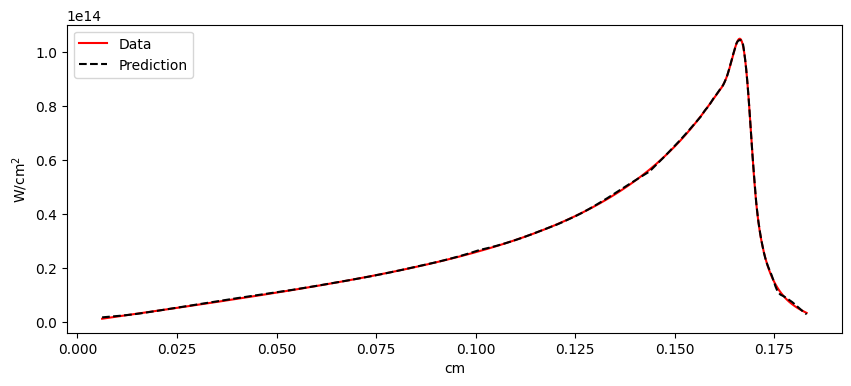

In [15]:
# And finally we can see that our network has done a decent job of estimating!
fig1, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(scaled_Qdata.index,plot_actual, 'r', label='Data')
ax1.plot(scaled_Qdata.index,plot_pred, 'k--', label='Prediction')
ax1.set_xlabel('cm')
ax1.set_ylabel('W/cm$^2$')
ax1.legend()

In [16]:
gradQpred=np.gradient(plot_pred, scaled_Qdata.index)
gradQact=np.gradient(plot_actual, scaled_Qdata.index)

Text(0, 0.5, 'W/cm$^3$')

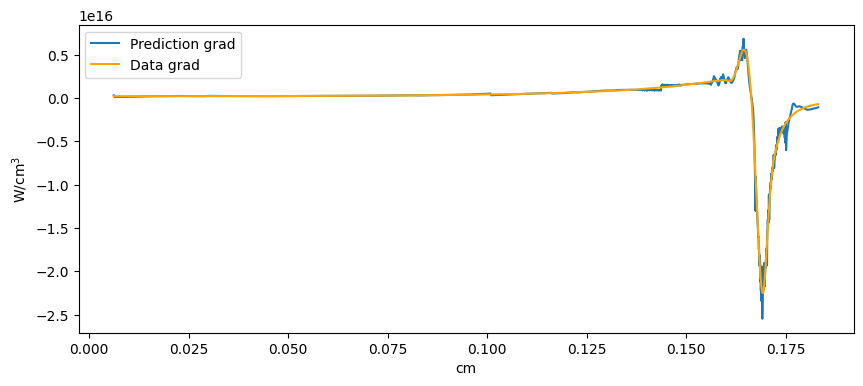

In [17]:
fig2, ax2 = plt.subplots(figsize=(10,4))
ax2.plot(scaled_Qdata.index,gradQpred, label='Prediction grad')
ax2.plot(scaled_Qdata.index,gradQact, label='Data grad', color='orange')
ax2.legend()
ax2.set_xlabel('cm')
ax2.set_ylabel('W/cm$^3$')